# DTSA 5511 Introduction to Deep Learning Final Project

## Background

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split

import keras_tuner
from keras_tuner import RandomSearch

2025-03-01 13:50:13.009559: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 13:50:13.253321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740808213.334483    1392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740808213.357542    1392 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 13:50:13.654154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Exploratory Data Analysis (EDA)
### Describe the data

In [3]:
data_dir = 'Dataset'
class_names = os.listdir(data_dir)
num_classes = len(class_names)

first_class_dir = os.path.join(data_dir, class_names[0])
first_image_path = os.path.join(first_class_dir, os.listdir(first_class_dir)[0])
sample_image = cv2.imread(first_image_path)
image_height, image_width, image_channels = sample_image.shape

In [5]:
print("Class count:", num_classes)
print("height:", image_height, "width:", image_width, "channels:", image_channels)

Class count: 4
height: 400 width: 600 channels: 3


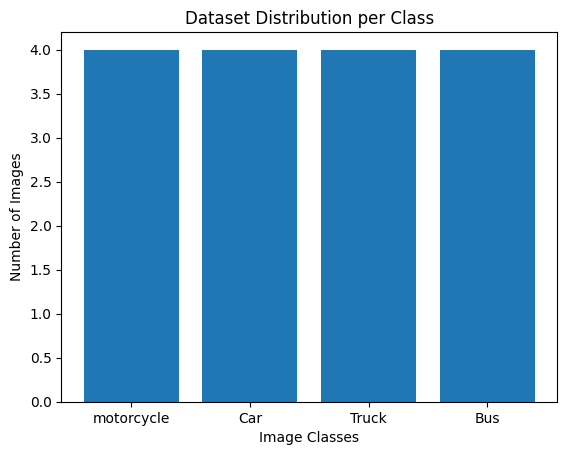

In [7]:
plt.bar(class_names, 4)
plt.xlabel('Image Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution per Class')
plt.show()

Per barplot, the data is evenly distributed between the 4 classes. The data is not imbalanced.
### Image preview

In [9]:
# Function to display image samples from a dataset
def display_image_samples(data_dir, class_names, num_samples_per_class):
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)
        random.shuffle(image_filenames)
        
        fig, axs = plt.subplots(1, num_samples_per_class, figsize=(12, 4))
        
        for i in range(num_samples_per_class):
            image_path = os.path.join(class_path, image_filenames[i])
            sample_image = cv2.imread(image_path)
            sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(sample_image)
            axs[i].axis('off')
            axs[i].set_title(f'Sample {i+1}')
        
        fig.suptitle(class_name, fontsize=14, fontweight='bold')
        plt.show()

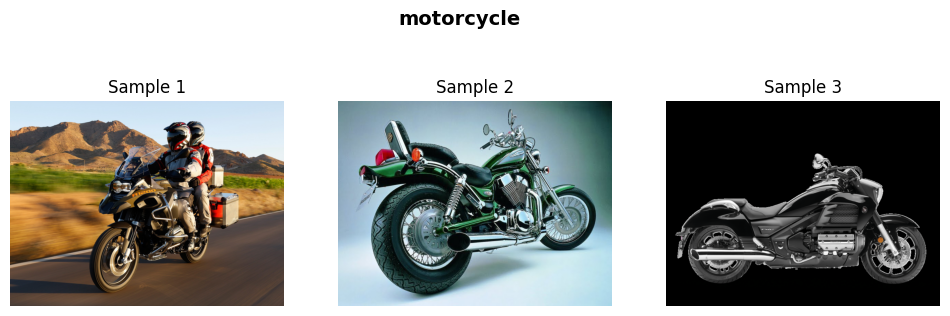

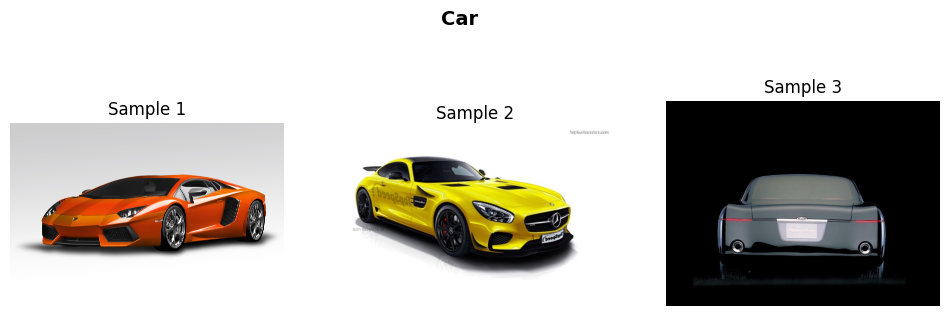

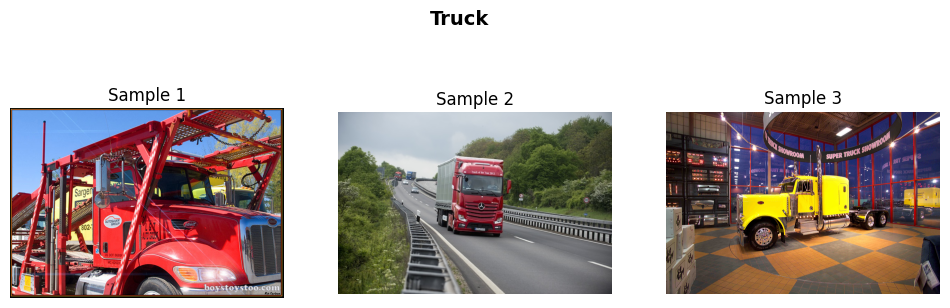

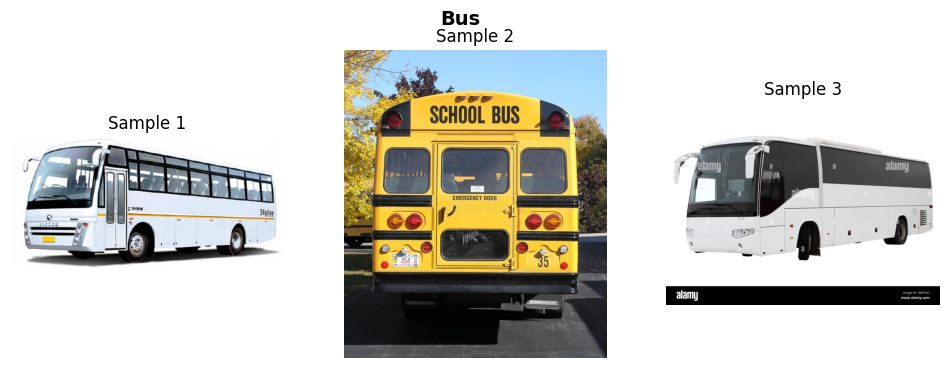

In [10]:
data_dir = 'Dataset'
num_samples_per_class = 3

class_names = os.listdir(data_dir)

display_image_samples(data_dir, class_names, num_samples_per_class)

Per inspection, images are:
- From various sources and various dimensions
- not preprocessed and are in their raw form
- not in grayscale and are in RGB format
- not normalized and are in their raw pixel values

Therefore, we are going to preprocess the images.

In [13]:
# Function to obtain image dimension statistics
def get_image_stats(data_dir, class_names):
    image_stats = []

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)

        for image_filename in image_filenames:
            image_path = os.path.join(class_path, image_filename)
            image = cv2.imread(image_path)
            image_stats.append(image.mean(axis=(0, 1)))

    image_stats = np.array(image_stats)
    mean_stats = image_stats.mean(axis=0)
    std_stats = image_stats.std(axis=0)

    print("Mean pixel values:", mean_stats)
    print("Standard deviation of pixel values:", std_stats)

In [14]:
get_image_stats(data_dir, class_names)

Mean pixel values: [114.06713775 118.03303583 123.34488098]
Standard deviation of pixel values: [41.74682924 39.56793569 40.1888138 ]


## Data Preprocessing
Resize images into a fixed dimension.

For models like ResNet-50, a common input size is 224x224 pixels. This size is a good balance between detail and computational efficiency.

Then split the data into training and validation sets.

In [16]:
data_dir = 'Dataset'
image_size = (224, 224)  # Desired fixed size
batch_size = 32

# Data augmentation and preprocessing
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

train_data = data_generator.flow_from_directory(
    directory=data_dir,
    target_size=image_size,  # Resize images to this size
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_data = data_generator.flow_from_directory(
    directory=data_dir,
    target_size=image_size,  # Resize images to this size
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 320 images belonging to 4 classes.


Found 80 images belonging to 4 classes.
